In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

## Setup
## Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
#url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:07<00:00, 182MB/s]


In [ ]:
filenames_list = []
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'

for filename in sorted(os.listdir(dataset_dir)):
    filenames_list.append(dataset_dir + filename)

filenames_list_train = filenames_list[:100000]
filenames_list_test = filenames_list[100001:120000]

print(len(filenames_list))

202599


In [ ]:
filenames_list_train[0]

'data/celeba/img_align_celeba/img_align_celeba/000001.jpg'

In [ ]:
#Denoise class
import numpy as np
from tensorflow.keras.utils import Sequence

from skimage import io, color , util
from skimage.transform import resize
from matplotlib import pyplot as plt

img_size = 128

class Generator(Sequence):

    def __init__(self, filenames_list, batch_size, img_size):
        self.filenames_list = filenames_list
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.filenames_list) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.filenames_list[idx * self.batch_size:(idx + 1) * self.batch_size]

        input_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        output_tensor = np.empty((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)

        i = 0
        for filename in batch_x:

            read_image = io.imread(filename)

            image = resize(read_image, (self.img_size, self.img_size), anti_aliasing=False, mode='constant')
            image_n = util.random_noise(image, mode='speckle')


            if image.shape == (self.img_size, self.img_size, 3) :
                # array image for output tensor
                output_tensor[i, :] = (image[:, :, :])
                # array values for input tensor
                input_tensor[i, :] = (image_n[:, :, :] ).reshape(img_size, img_size, 3)
                i += 1

                # print(image)
                # io.imshow(image_n)
                # plt.show()


        return input_tensor, output_tensor




In [ ]:
import os
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, ZeroPadding2D, Concatenate, AveragePooling2D, UpSampling2D
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
##from keras.utils import plot_model
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Sun Dec 26 03:02:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    32W / 250W |   1123MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Root directory for the logs
log_root = f'{data_root}/logs'
# Path to folder with the dataset
weights_root = f'{data_root}//weights'

# Create required directories 
if not os.path.exists(log_root):
  os.makedirs(log_root)
  os.makedirs(weights_root)

In [ ]:
img_size = 128
batch_size = 32

training_batch_generator = Generator(filenames_list=filenames_list_train, batch_size=batch_size, img_size=img_size)
testing_batch_generator = Generator(filenames_list=filenames_list_test, batch_size=batch_size, img_size=img_size)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))


In [ ]:
# model

input_layer = Input(shape=(img_size, img_size, 3))

hidden_layer_1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_layer)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_1 = AveragePooling2D()(hidden_layer_1)
hidden_layer_2 = Conv2D(64, (5, 5), activation='relu',  padding='same')(hidden_layer_1)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_2 = AveragePooling2D()(hidden_layer_2)
hidden_layer_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(hidden_layer_2)
hidden_layer_3 = BatchNormalization()(hidden_layer_3)
hidden_layer_3 = UpSampling2D()(hidden_layer_3)
hidden_layer_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(hidden_layer_3)
hidden_layer_4 = BatchNormalization()(hidden_layer_4)
hidden_layer_4 = UpSampling2D()(hidden_layer_4)
hidden_layer_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(hidden_layer_4)
hidden_layer_5 = BatchNormalization()(hidden_layer_5)

output_layer = Conv2D(3, (3, 3), activation='tanh', padding='same')(hidden_layer_5)

model = Model(inputs=input_layer, outputs=output_layer)

opt = tensorflow.keras.optimizers.RMSprop()

model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

#plot_model(model, to_file='logs/cnn/cnn_model.png')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4736      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 64)       256   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
3125/3125 [==============================] - 900s 284ms/step - loss: 0.0070 - accuracy: 0.8114 - val_loss: 0.0017 - val_accuracy: 0.7569
Epoch 2/10
3125/3125 [==============================] - 887s 283ms/step - loss: 0.0017 - accuracy: 0.8487 - val_loss: 0.0020 - val_accuracy: 0.8167
Epoch 3/10
3125/3125 [==============================] - 901s 288ms/step - loss: 0.0013 - accuracy: 0.8568 - val_loss: 0.0013 - val_accuracy: 0.8887
Epoch 4/10
3125/3125 [==============================] - 920s 294ms/step - loss: 0.0011 - accuracy: 0.8622 - val_loss: 0.0013 - val_accuracy: 0.8009
Epoch 5/10
3125/3125 [==============================] - 932s 297ms/step - loss: 9.7249e-04 - accuracy: 0.8658 - val_loss: 9.0021e-04 - val_accuracy: 0.8555
Epoch 6/10
3125/3125 [==============================] - 940s 300ms/step - loss: 9.0187e-04 - accuracy: 0.8682 - val_loss: 0.0010 - val_accuracy: 0.8429
Epoch 7/10
3125/3125 [==============================] - 936s 299ms/step - loss: 8.4382e-04 - accurac

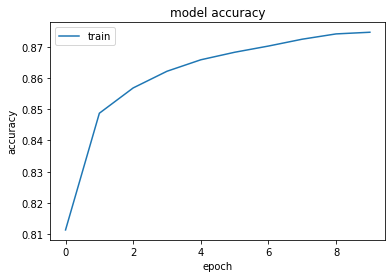

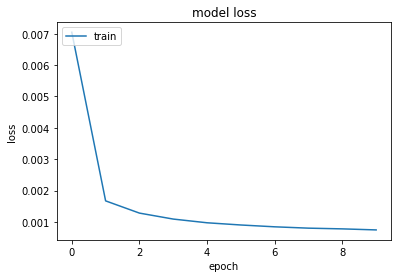

In [ ]:
with tf.device("/gpu:0"):
   history = model.fit_generator(training_batch_generator, epochs=10, verbose=1, use_multiprocessing=True,
                        workers=8,validation_data = testing_batch_generator)

   print(history.history.keys())
   #summarize history for accuracy
   plt.plot(history.history['accuracy'])
   #plt.plot(history.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/accuracy_plot.png")
   plt.show()
   # summarize history for loss
   plt.plot(history.history['loss'])
   #plt.plot(history.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.savefig(log_root+"/loss_plot.png")
   plt.show()

model.save(weights_root+"/AECNNs.h5")

In [ ]:
import numpy as np
import os
from keras.models import load_model
import matplotlib.pyplot as plt
from skimage import io, color , util
from skimage.transform import resize
import pandas as pd

In [ ]:
img_size = 128
dataset_dir = f'{data_root}/img_align_celeba/img_align_celeba/'

def ret_input_output_tensor(dataset_dir, n_images):
    input_tensor = np.empty((n_images, img_size, img_size, 3))
    output_tensor = np.empty((n_images, img_size, img_size, 3))

    i = 0
    print(len(os.listdir(dataset_dir)))
    for filename in reversed(sorted(os.listdir(dataset_dir))):

        if filename.endswith('.jpg'):

            image = io.imread(dataset_dir + filename)
            image = resize(image, (img_size, img_size, 3), anti_aliasing=False, mode='constant')
            image_n = util.random_noise(image, mode='speckle')


            if image.shape == (img_size, img_size, 3):  # if not a BW image
                # array image for output tensor
                output_tensor[i, :] = (image[:, :, :])
                # array values for input tensor
                input_tensor[i, :] = (image_n[:, :, :]).reshape(img_size, img_size, 3)
                i += 1

        if i >= n_images: break

    return input_tensor, output_tensor

In [ ]:
print(os.listdir())
model = load_model("/content/data/AECNNs.h5")

# prediction

input_tensor, output_tensor = ret_input_output_tensor(dataset_dir, 10)
prediction = model.predict(input_tensor)

['.config', 'data', 'sample_data']
202599


input tensor :
 (128, 128, 3)
(128, 128, 3)


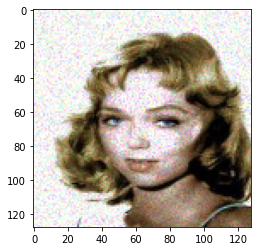

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


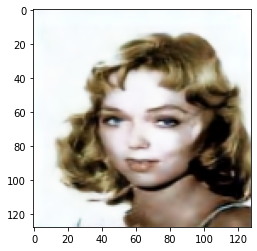

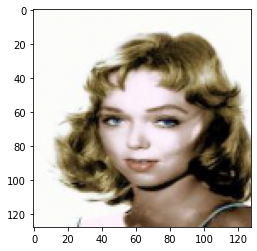

input tensor :
 (128, 128, 3)
(128, 128, 3)


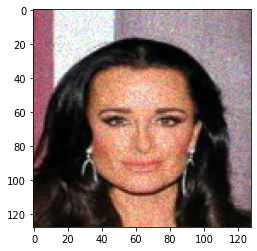

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


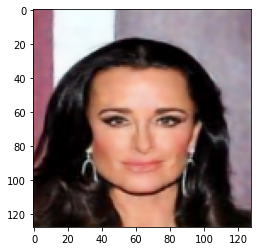

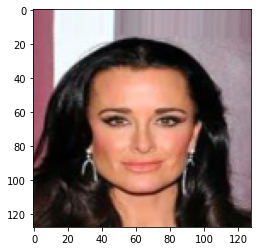

input tensor :
 (128, 128, 3)
(128, 128, 3)


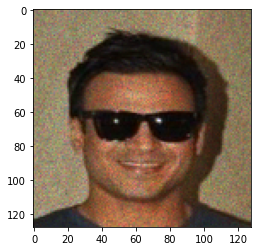

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


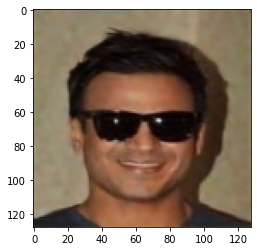

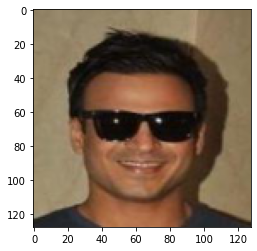

input tensor :
 (128, 128, 3)
(128, 128, 3)


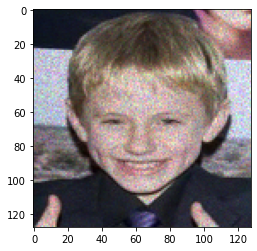

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


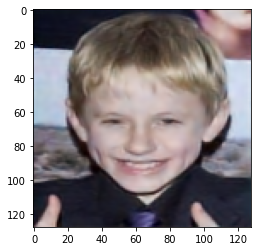

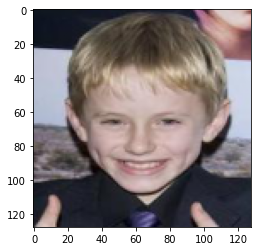

input tensor :
 (128, 128, 3)
(128, 128, 3)


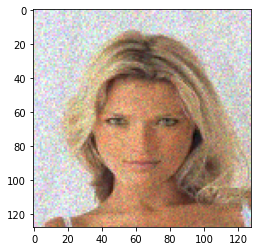

(128, 128, 3)


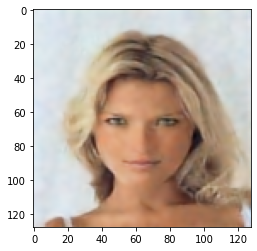

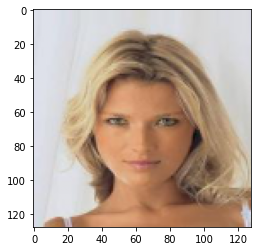

input tensor :
 (128, 128, 3)
(128, 128, 3)


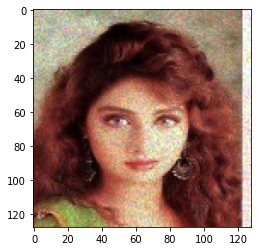

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


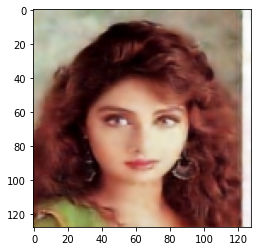

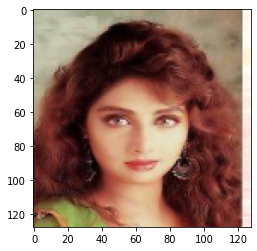

input tensor :
 (128, 128, 3)
(128, 128, 3)


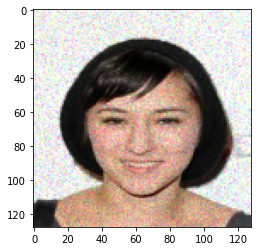

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


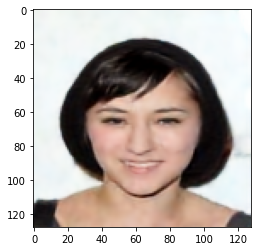

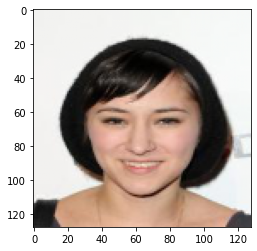

input tensor :
 (128, 128, 3)
(128, 128, 3)


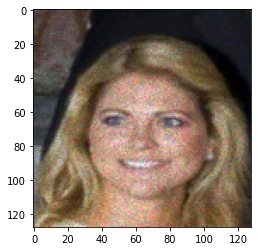

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


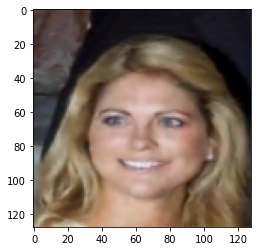

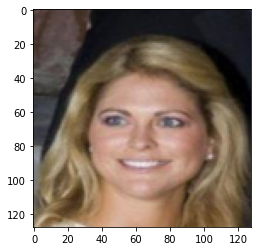

input tensor :
 (128, 128, 3)
(128, 128, 3)


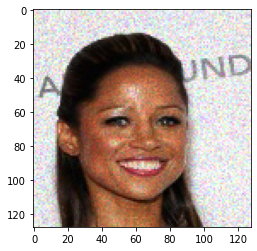

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


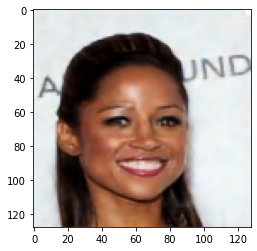

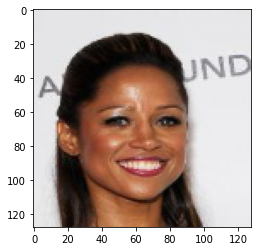

input tensor :
 (128, 128, 3)
(128, 128, 3)


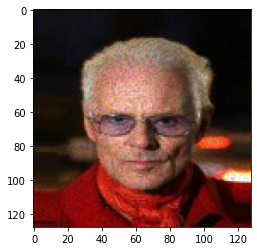

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128, 3)


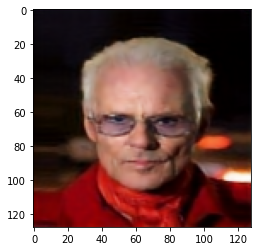

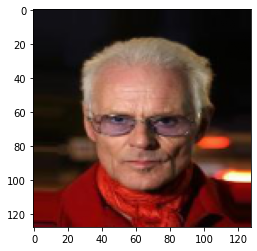

In [ ]:
for i in range(10):
    print("input tensor :\n", input_tensor[i].shape)
    #print("prediction :\n", prediction[i])
    #print("output tensor :\n", output_tensor[i])

    input_image = input_tensor[i]
    print(input_image.shape)
    plt.imshow(input_image)
    plt.show()
    plt.imsave('/content/data/celeba/logs/'+str(i)+'_input.png', input_image)

    output_image = prediction[i]
    print(output_image.shape)

    plt.imshow(output_image)
    plt.show()
    #plt.savefig('/content/data/celeba/logs/' + str(i) + '_prediction.png')
    #plt.imsave('/content/data/celeba/logs/' + str(i) + '_prediction.png', img_data_clamped)



    output_image = output_tensor[i]
    plt.imshow(output_image)
    plt.show()
    plt.imsave('/content/data/celeba/logs/' + str(i) + '_actual.png', output_image)

In [ ]:
!zip -r /content/data/logs.zip /content/data/celeba/logs

  adding: content/data/celeba/logs/ (stored 0%)
  adding: content/data/celeba/logs/accuracy_plot.png (deflated 9%)
  adding: content/data/celeba/logs/6_actual.png (deflated 0%)
  adding: content/data/celeba/logs/5_actual.png (deflated 0%)
  adding: content/data/celeba/logs/7_actual.png (deflated 0%)
  adding: content/data/celeba/logs/0_actual.png (stored 0%)
  adding: content/data/celeba/logs/9_actual.png (stored 0%)
  adding: content/data/celeba/logs/2_actual.png (stored 0%)
  adding: content/data/celeba/logs/1_input.png (deflated 0%)
  adding: content/data/celeba/logs/8_actual.png (deflated 0%)
  adding: content/data/celeba/logs/5_input.png (deflated 0%)
  adding: content/data/celeba/logs/3_actual.png (deflated 0%)
  adding: content/data/celeba/logs/3_input.png (deflated 0%)
  adding: content/data/celeba/logs/0_input.png (deflated 0%)
  adding: content/data/celeba/logs/8_input.png (deflated 0%)
  adding: content/data/celeba/logs/9_input.png (deflated 0%)
  adding: content/data/celeba